In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import cv2

@dataclass
class Config:
    root: str = "C:\\Users\\asap0\\OneDrive\\바탕 화면\\yonsei\\26-1 DSL\\eda\\SemiConductor_EDA_2602\\LithoBench\\0_Datasets\\lithodata\\StdMetal" # <-- change to your path
    folders: Tuple[str, ...] = ("litho", "pixelILT", "printed", "resist", "target")

    # binary vs gray stages
    binary_stages: Tuple[str, ...] = ("target", "pixelILT", "printed")
    gray_stages: Tuple[str, ...] = ("litho", "resist")

    thresholds: Tuple[float, ...] = (0.30, 0.40, 0.50)

    # Morph cleanup kernel size (set 0 to disable)
    morph_k: int = 3

    out_csv: str = "eda_6stage_features_errors.csv"


CFG = Config()


#File indexing (filename-based matching)
def list_files(folder: Path) -> Dict[str, Path]:
    return {p.name: p for p in folder.iterdir() if p.is_file()}


def build_index(cfg: Config) -> Tuple[Dict[str, Dict[str, Path]], List[str]]:
    root = Path(cfg.root)
    if not root.exists():
        raise FileNotFoundError(f"Root not found: {root.resolve()}")

    maps: Dict[str, Dict[str, Path]] = {}
    for f in cfg.folders:
        fp = root / f
        if not fp.exists():
            raise FileNotFoundError(f"Missing folder: {fp.resolve()}")
        maps[f] = list_files(fp)

    common = set(maps[cfg.folders[0]].keys())
    for f in cfg.folders[1:]:
        common &= set(maps[f].keys())
    common = sorted(common)

    if len(common) == 0:
        raise RuntimeError("No common filenames across all 6 folders.")

    # quick report
    for f in cfg.folders:
        miss = sorted(set(common) - set(maps[f].keys()))
        extra = sorted(set(maps[f].keys()) - set(common))
        if miss:
            print(f"[WARN] {f}: missing {len(miss)} (first 5): {miss[:5]}")
        if extra:
            print(f"[INFO] {f}: extra {len(extra)} (first 5): {extra[:5]}")

    print(f"[OK] common masks = {len(common)}")
    return maps, common


#Robust loader (png/jpg + npy)
def load_as_float01(path: Path) -> np.ndarray:
    suf = path.suffix.lower()
    if suf == ".npy":
        arr = np.load(path)
        arr = np.asarray(arr)
        if arr.ndim == 3:
            arr = arr.mean(axis=-1)
        arr = arr.astype(np.float32)
        mn, mx = float(arr.min()), float(arr.max())
        if mx - mn < 1e-8:
            return np.zeros_like(arr, dtype=np.float32)
        return (arr - mn) / (mx - mn)

    # png/jpg
    if not path.exists() or path.stat().st_size == 0:
        raise ValueError(f"Missing or empty file: {path}")

    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        # fallback: PIL
        from PIL import Image
        with Image.open(path) as im:
            img = np.array(im.convert("L"))

    return img.astype(np.float32) / 255.0


# Part 3) Binarization + cleanup
def otsu_binarize(img01: np.ndarray, auto_invert: bool = True) -> np.ndarray:
    img8 = np.clip(img01 * 255.0, 0, 255).astype(np.uint8)
    blur = cv2.GaussianBlur(img8, (5, 5), 0)
    _, b = cv2.threshold(blur, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if auto_invert and b.mean() > 0.5:
        b = 1 - b
    return b.astype(np.uint8)


def threshold_binarize(img01: np.ndarray, thr: float, auto_invert: bool = True) -> np.ndarray:
    b = (img01 > thr).astype(np.uint8)
    if auto_invert and b.mean() > 0.5:
        b = 1 - b
    return b


def cleanup_binary(bin01: np.ndarray, k: int) -> np.ndarray:
    if k is None or k <= 0:
        return bin01.astype(np.uint8)
    kernel = np.ones((k, k), np.uint8)
    x = cv2.morphologyEx(bin01.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, kernel)
    return x.astype(np.uint8)


#Target feature extraction (geometry / complexity)
def perimeter_px(bin01: np.ndarray) -> int:
    edge = cv2.Canny((bin01 * 255).astype(np.uint8), 50, 150)
    return int((edge > 0).sum())


def count_components(bin01: np.ndarray) -> int:
    num, _ = cv2.connectedComponents((bin01 > 0).astype(np.uint8), connectivity=4)
    return int(num - 1)


def extract_target_features(target_bin: np.ndarray) -> Dict[str, float]:
    area_frac = float(target_bin.mean())
    perim = float(perimeter_px(target_bin))
    comps = float(count_components(target_bin))
    area = float(target_bin.sum()) + 1e-6
    compact = float((perim * perim) / area)
    edge = cv2.Canny((target_bin * 255).astype(np.uint8), 50, 150)
    edge_density = float((edge > 0).mean())

    return {
        "target_area_frac": area_frac,
        "target_perimeter": perim,
        "target_components": comps,
        "target_compactness": compact,
        "target_edge_density": edge_density,
    }


#Error metrics (IoU / XOR / component delta)
def iou(a: np.ndarray, b: np.ndarray) -> float:
    a = (a > 0)
    b = (b > 0)
    inter = np.logical_and(a, b).sum()
    uni = np.logical_or(a, b).sum()
    return float(inter / (uni + 1e-8))


def xor_rate(a: np.ndarray, b: np.ndarray) -> float:
    a = (a > 0)
    b = (b > 0)
    x = np.logical_xor(a, b).sum()
    uni = np.logical_or(a, b).sum()
    return float(x / (uni + 1e-8))


def comp_delta(a: np.ndarray, b: np.ndarray) -> int:
    return int(count_components(b) - count_components(a))

#Optional alignment sanity check (centroid shift)
def centroid_xy(bin01: np.ndarray) -> Tuple[float, float]:
    ys, xs = np.where(bin01 > 0)
    if len(xs) == 0:
        return (np.nan, np.nan)
    return float(xs.mean()), float(ys.mean())


def centroid_shift(a: np.ndarray, b: np.ndarray) -> float:
    ax, ay = centroid_xy(a)
    bx, by = centroid_xy(b)
    if np.isnan(ax) or np.isnan(bx):
        return float("nan")
    return float(np.sqrt((ax - bx) ** 2 + (ay - by) ** 2))


#Process one mask (load -> preprocess -> features/errors)
def process_one(name: str, maps: Dict[str, Dict[str, Path]], cfg: Config) -> Dict[str, float]:
    # Load float01
    imgs = {st: load_as_float01(maps[st][name]) for st in cfg.folders}

    # Binarize binary-stages (Otsu)
    bins = {}
    for st in cfg.binary_stages:
        b = otsu_binarize(imgs[st], auto_invert=True)
        b = cleanup_binary(b, cfg.morph_k)
        bins[st] = b

    # Gray stages -> multi-threshold bins
    gray_bins: Dict[str, Dict[float, np.ndarray]] = {}
    for st in cfg.gray_stages:
        gray_bins[st] = {}
        for t in cfg.thresholds:
            b = threshold_binarize(imgs[st], float(t), auto_invert=True)
            b = cleanup_binary(b, cfg.morph_k)
            gray_bins[st][float(t)] = b

    # Row: id + target features
    row: Dict[str, float] = {"mask_name": name}
    row.update(extract_target_features(bins["target"]))

    # Alignment sanity: target vs printed
    row["shift_target_printed"] = centroid_shift(bins["target"], bins["printed"])

    # --- Stage-wise: target vs (glp, pixelILT, printed)
    # row["iou_target_glp"] = iou(bins["target"], bins["glp"])
    # row["xor_target_glp"] = xor_rate(bins["target"], bins["glp"])

    row["iou_target_pixelILT"] = iou(bins["target"], bins["pixelILT"])
    row["xor_target_pixelILT"] = xor_rate(bins["target"], bins["pixelILT"])

    row["iou_target_printed"] = iou(bins["target"], bins["printed"])
    row["xor_target_printed"] = xor_rate(bins["target"], bins["printed"])
    row["comp_delta_target_printed"] = comp_delta(bins["target"], bins["printed"])

    # --- Stage-wise: (glp or pixelILT) -> litho -> resist -> printed (threshold별)
    # glp -> litho
    for t in cfg.thresholds:
        lt = gray_bins["litho"][float(t)]
        # row[f"iou_glp_litho_t{t:.2f}"] = iou(bins["glp"], lt)
        # row[f"xor_glp_litho_t{t:.2f}"] = xor_rate(bins["glp"], lt)

        row[f"iou_pixelILT_litho_t{t:.2f}"] = iou(bins["pixelILT"], lt)
        row[f"xor_pixelILT_litho_t{t:.2f}"] = xor_rate(bins["pixelILT"], lt)

    # litho -> resist
    for t in cfg.thresholds:
        lt = gray_bins["litho"][float(t)]
        rt = gray_bins["resist"][float(t)]
        row[f"iou_litho_resist_t{t:.2f}"] = iou(lt, rt)
        row[f"xor_litho_resist_t{t:.2f}"] = xor_rate(lt, rt)

    # resist -> printed
    for t in cfg.thresholds:
        rt = gray_bins["resist"][float(t)]
        row[f"iou_resist_printed_t{t:.2f}"] = iou(rt, bins["printed"])
        row[f"xor_resist_printed_t{t:.2f}"] = xor_rate(rt, bins["printed"])
        row[f"comp_delta_resist_printed_t{t:.2f}"] = comp_delta(rt, bins["printed"])

    # Threshold stability summary (resist->printed)
    rp_ious = [row[f"iou_resist_printed_t{t:.2f}"] for t in cfg.thresholds]
    row["iou_resist_printed_mean"] = float(np.mean(rp_ious))
    row["iou_resist_printed_std"] = float(np.std(rp_ious))

    return row


def run(cfg: Config) -> pd.DataFrame:
    maps, common = build_index(cfg)

    rows = []
    for i, name in enumerate(common, 1):
        try:
            rows.append(process_one(name, maps, cfg))
        except Exception as e:
            print(f"[ERROR] {name}: {e}")

        if i % 50 == 0 or i == len(common):
            print(f"Processed {i}/{len(common)}")

    df = pd.DataFrame(rows)
    df.to_csv(cfg.out_csv, index=False, encoding="utf-8-sig")
    print(f"[DONE] Saved {cfg.out_csv} | rows={len(df)} cols={df.shape[1]}")
    return df


if __name__ == "__main__":
    df = run(CFG)
    print(df.head(3).to_string(index=False))

[OK] common masks = 271
Processed 50/271
Processed 100/271
Processed 150/271
Processed 200/271
Processed 250/271
Processed 271/271
[DONE] Saved eda_6stage_features_errors.csv | rows=271 cols=35
       mask_name  target_area_frac  target_perimeter  target_components  target_compactness  target_edge_density  shift_target_printed  iou_target_pixelILT  xor_target_pixelILT  iou_target_printed  xor_target_printed  comp_delta_target_printed  iou_pixelILT_litho_t0.30  xor_pixelILT_litho_t0.30  iou_pixelILT_litho_t0.40  xor_pixelILT_litho_t0.40  iou_pixelILT_litho_t0.50  xor_pixelILT_litho_t0.50  iou_litho_resist_t0.30  xor_litho_resist_t0.30  iou_litho_resist_t0.40  xor_litho_resist_t0.40  iou_litho_resist_t0.50  xor_litho_resist_t0.50  iou_resist_printed_t0.30  xor_resist_printed_t0.30  comp_delta_resist_printed_t0.30  iou_resist_printed_t0.40  xor_resist_printed_t0.40  comp_delta_resist_printed_t0.40  iou_resist_printed_t0.50  xor_resist_printed_t0.50  comp_delta_resist_printed_t0.50  iou_re

In [31]:
display(df)

,mask_name,target_area_frac,target_perimeter,target_components,target_compactness,target_edge_density,shift_target_printed,iou_target_pixelILT,xor_target_pixelILT,iou_target_printed,...,comp_delta_resist_printed_t0.40,iou_resist_printed_t0.50,xor_resist_printed_t0.50,comp_delta_resist_printed_t0.50,iou_resist_printed_mean,iou_resist_printed_std,final_error,ed_penalty,cp_penalty,score
0,TLAT_X1__2_0.png,0.040196,3994.0,2.0,94.618053,0.000952,3.468074,0.358825,0.641175,0.944023,...,0,1.000000,0.000000,0,0.949136,0.041664,0.055977,0.000226,12.422043,4.298660
1,SDFFRS_X2__0_0.png,0.039758,3930.0,3.0,92.619756,0.000937,5.384204,0.417536,0.582464,0.942763,...,0,1.000000,0.000000,0,0.948778,0.042005,0.057237,0.000211,10.423746,3.768862
2,OR3_X2__0_1.png,0.074096,5782.0,4.0,107.571920,0.001379,9.924024,0.474479,0.525521,0.936407,...,0,1.000000,0.000000,0,0.958638,0.034141,0.063593,0.000652,25.375910,3.514460
3,AND3_X2__0_0.png,0.071727,5502.0,4.0,100.623927,0.001312,13.918298,0.516124,0.483876,0.928295,...,0,0.999997,0.000003,0,0.959753,0.033210,0.071705,0.000586,18.427916,1.731617
4,NAND4_X2__0_0.png,0.032785,3426.0,2.0,85.357875,0.000817,3.794072,0.359879,0.640121,0.931533,...,0,1.000000,0.000000,0,0.944977,0.045159,0.068467,0.000091,3.161864,1.283362
5,SDFFR_X1__0_0.png,0.033531,4200.0,3.0,125.425729,0.001001,8.867999,0.402022,0.597978,0.936438,...,0,1.000000,0.000000,0,0.929733,0.057065,0.063562,0.000275,43.229719,0.916485
6,DLL_X1__0_0.png,0.033585,3236.0,2.0,74.339050,0.000772,2.508349,0.386517,0.613483,0.928250,...,0,1.000000,0.000000,0,0.948754,0.041884,0.071750,0.000045,7.856960,0.626732
7,NAND4_X2__1_0.png,0.032785,3426.0,2.0,85.357875,0.000817,5.325662,0.406695,0.593305,0.924519,...,0,1.000000,0.000000,0,0.942865,0.046640,0.075481,0.000091,3.161864,-0.356938
8,DLH_X1__1_0.png,0.044679,4800.0,2.0,122.946227,0.001144,2.866324,0.382987,0.617013,0.923637,...,0,1.000000,0.000000,0,0.943891,0.045873,0.076363,0.000418,40.750217,-1.166257
9,MUX2_X2__1_1.png,0.033135,3564.0,2.0,91.395794,0.000850,3.627915,0.385288,0.614712,0.921352,...,0,1.000000,0.000000,0,0.943082,0.046552,0.078648,0.000124,9.199783,-1.277026


In [32]:
output_path = r'C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\BaekGaeun\eda_6stage_features_errors.csv'


Loaded: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\BaekGaeun\eda_6stage_features_errors.csv
Shape: (271, 35)
Columns: 35


C:\Users\asap0\AppData\Local\Temp\ipykernel_44856\427523122.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


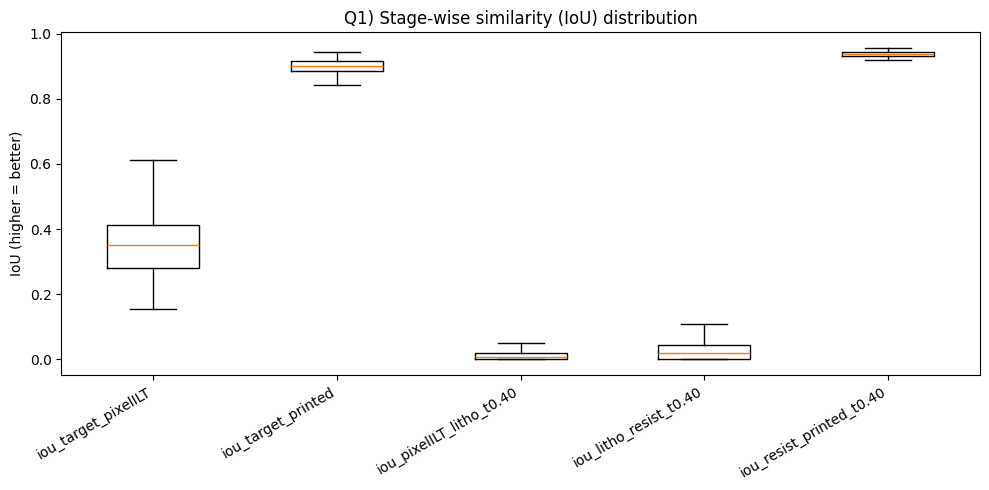

C:\Users\asap0\AppData\Local\Temp\ipykernel_44856\427523122.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


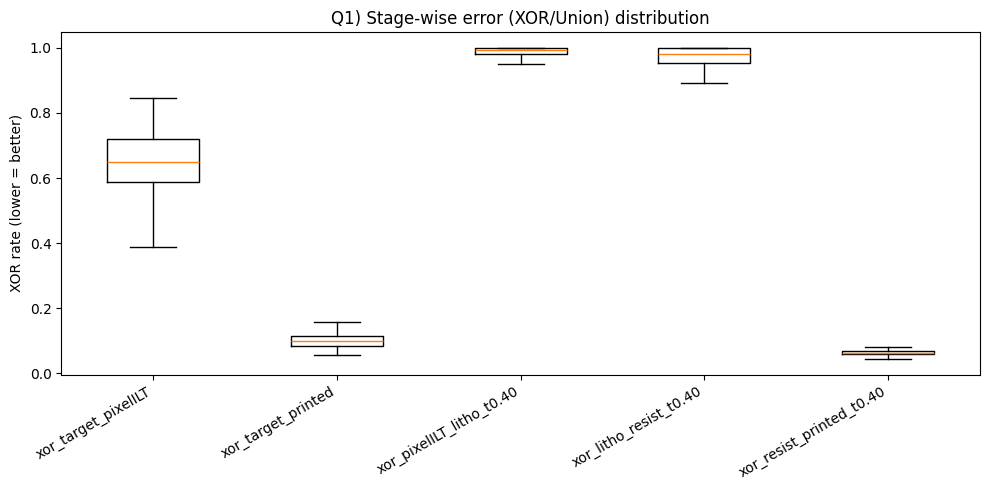

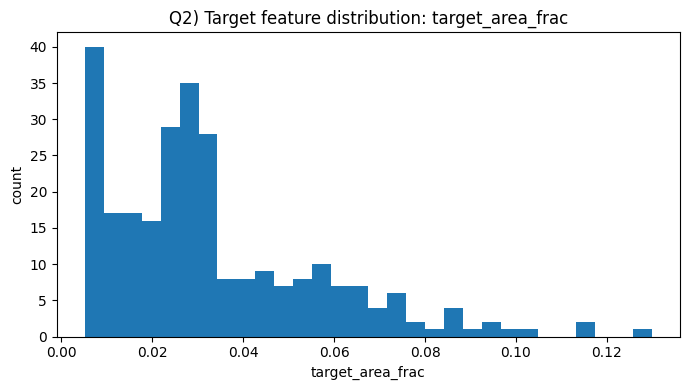

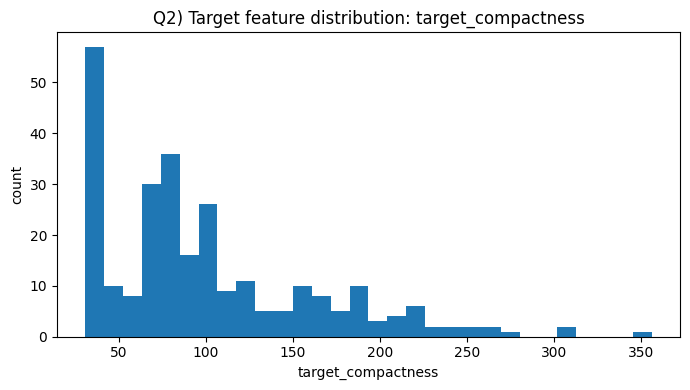

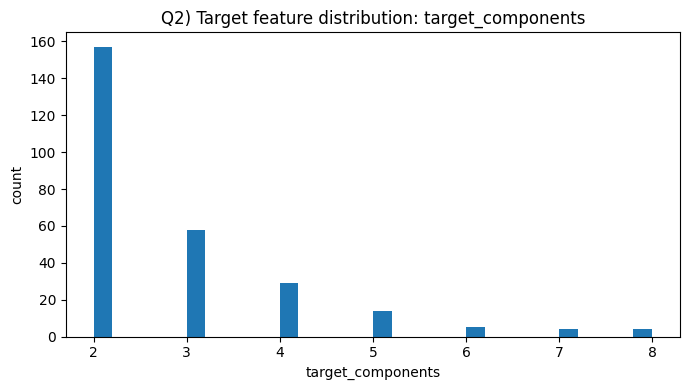

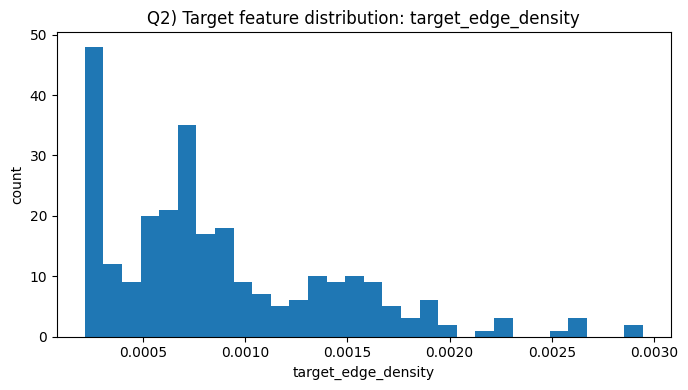

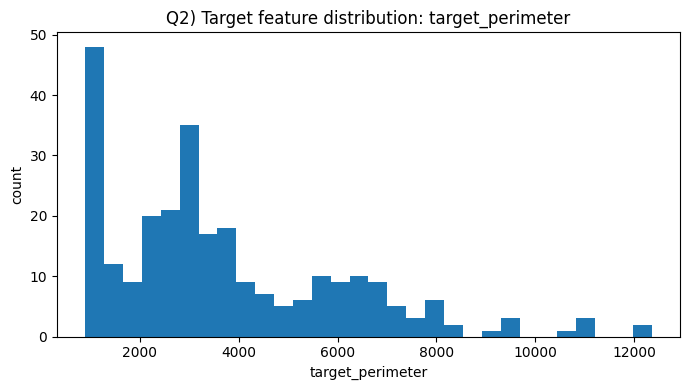

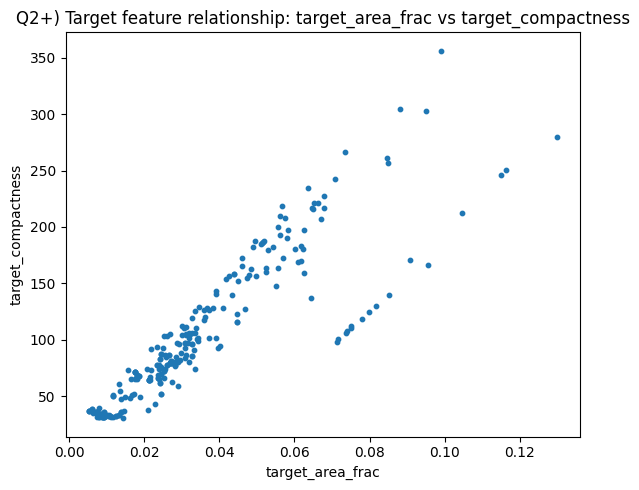

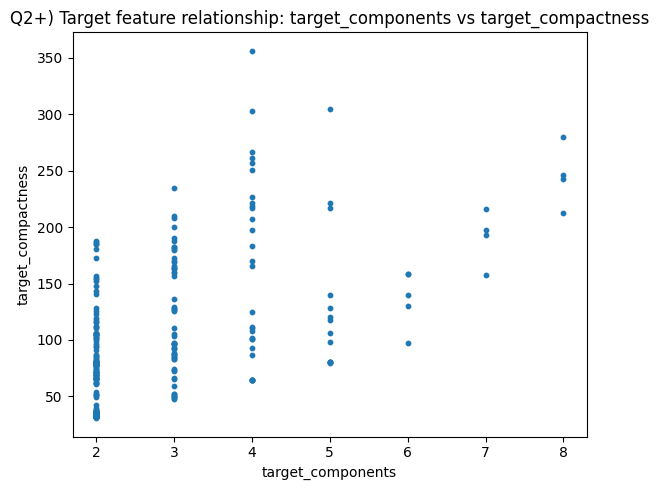

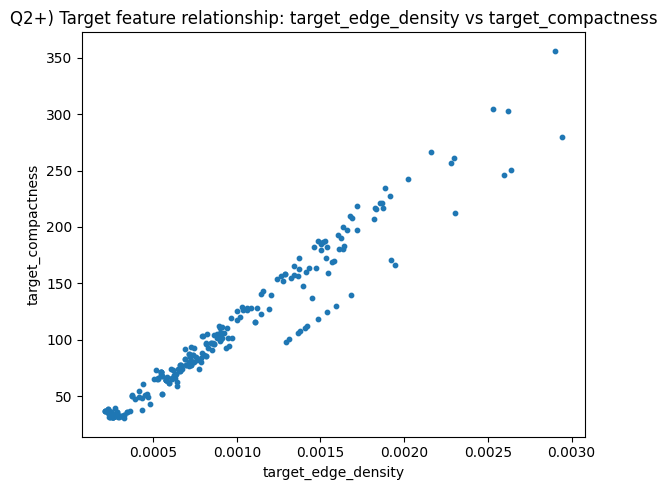

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = r'C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\BaekGaeun\eda_6stage_features_errors.csv'  # 필요시 수정
df = pd.read_csv(CSV_PATH)

OUT_DIR = Path("./eda_step1_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Loaded:", CSV_PATH)
print("Shape:", df.shape)
print("Columns:", len(df.columns))


# Q1) “공정 단계별로 Error는 어디에서 가장 크게 발생하는가?”
def pick_threshold(df_cols, base_prefix: str, prefer: str = "t0.40") -> list[str]:
    """
    base_prefix 예: "iou_glp_litho_", "xor_resist_printed_"
    prefer 예: "t0.40" (없으면 다른 t 선택)
    """
    candidates = [c for c in df_cols if c.startswith(base_prefix)]
    if not candidates:
        return []

    # prefer가 있는지 먼저 찾고, 없으면 가장 앞(정렬) 사용
    preferred = [c for c in candidates if prefer in c]
    if preferred:
        return preferred

    # 없으면 t0.50, t0.30 등 중 하나 선택 (정렬 후 첫번째)
    return [sorted(candidates)[0]]


def make_stage_boxplot(df: pd.DataFrame, cols: list[str], title: str, ylabel: str, out_png: Path):
    # 결측 제거한 값들로 boxplot
    data = [df[c].dropna().values for c in cols]
    labels = cols

    plt.figure(figsize=(max(10, len(cols) * 1.2), 5))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.xticks(rotation=30, ha="right")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

cols = df.columns.tolist()

# IoU 선택
iou_cols = []

# 고정(단일) 컬럼
for c in ["iou_target_glp", "iou_target_pixelILT", "iou_target_printed"]:
    if c in df.columns:
        iou_cols.append(c)

# threshold 있는 컬럼들: prefer t0.40
iou_cols += pick_threshold(cols, "iou_glp_litho_", prefer="t0.40")
iou_cols += pick_threshold(cols, "iou_pixelILT_litho_", prefer="t0.40")
iou_cols += pick_threshold(cols, "iou_litho_resist_", prefer="t0.40")
iou_cols += pick_threshold(cols, "iou_resist_printed_", prefer="t0.40")

# 중복 제거 + 존재 확인
iou_cols = [c for i, c in enumerate(iou_cols) if c in df.columns and c not in iou_cols[:i]]

if len(iou_cols) == 0:
    print("[WARN] IoU 관련 컬럼을 찾지 못했습니다. 컬럼명을 확인하세요.")
else:
    make_stage_boxplot(
        df, iou_cols,
        title="Q1) Stage-wise similarity (IoU) distribution",
        ylabel="IoU (higher = better)",
        out_png=OUT_DIR / "Q1_stagewise_iou_boxplot.png"
    )

# XOR 선택 (error 관점: 낮을수록 좋음)
xor_cols = []

for c in ["xor_target_glp", "xor_target_pixelILT", "xor_target_printed"]:
    if c in df.columns:
        xor_cols.append(c)

xor_cols += pick_threshold(cols, "xor_glp_litho_", prefer="t0.40")
xor_cols += pick_threshold(cols, "xor_pixelILT_litho_", prefer="t0.40")
xor_cols += pick_threshold(cols, "xor_litho_resist_", prefer="t0.40")
xor_cols += pick_threshold(cols, "xor_resist_printed_", prefer="t0.40")

xor_cols = [c for i, c in enumerate(xor_cols) if c in df.columns and c not in xor_cols[:i]]

if len(xor_cols) == 0:
    print("[WARN] XOR 관련 컬럼을 찾지 못했습니다. 컬럼명을 확인하세요.")
else:
    make_stage_boxplot(
        df, xor_cols,
        title="Q1) Stage-wise error (XOR/Union) distribution",
        ylabel="XOR rate (lower = better)",
        out_png=OUT_DIR / "Q1_stagewise_xor_boxplot.png"
    )


# Q2) “우리 데이터셋의 target 패턴은 얼마나 다양한가?”

target_feats = [
    "target_area_frac",
    "target_compactness",
    "target_components",
    "target_edge_density",
    "target_perimeter",
]

available_feats = [c for c in target_feats if c in df.columns]
if len(available_feats) == 0:
    print("[WARN] target feature 컬럼을 찾지 못했습니다. 컬럼명을 확인하세요.")
else:
    for feat in available_feats:
        x = df[feat].dropna().values

        plt.figure(figsize=(7, 4))
        plt.hist(x, bins=30)
        plt.title(f"Q2) Target feature distribution: {feat}")
        plt.xlabel(feat)
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()
        # Removed out_png = OUT_DIR / f"Q2_target_hist_{feat}.png"
        # Removed plt.savefig(out_png, dpi=200)
        # Removed print("Saved:", out_png)


#Q2) “Target feature들끼리 서로 어떤 관계가 있나?”

pairs = [
    ("target_area_frac", "target_compactness"),
    ("target_components", "target_compactness"),
    ("target_edge_density", "target_compactness"),
]

for a, b in pairs:
    if a in df.columns and b in df.columns:
        plt.figure(figsize=(6, 5))
        plt.scatter(df[a], df[b], s=10)
        plt.title(f"Q2+) Target feature relationship: {a} vs {b}")
        plt.xlabel(a)
        plt.ylabel(b)
        plt.tight_layout()
        plt.show()

Loaded: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\BaekGaeun\eda_6stage_features_errors.csv
Shape: (271, 35)


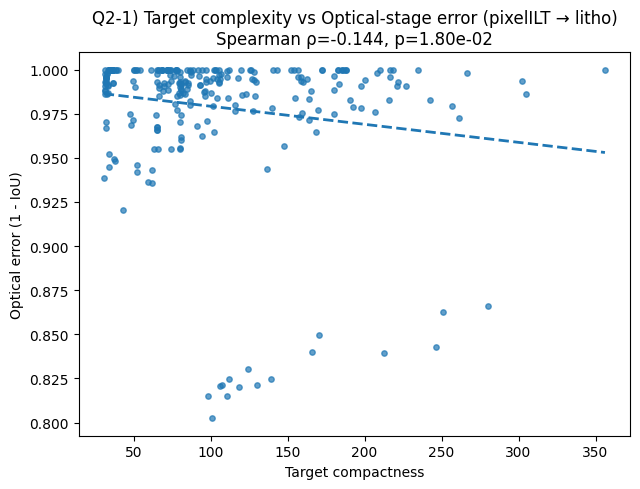

  Spearman rho = -0.144, p = 1.80e-02



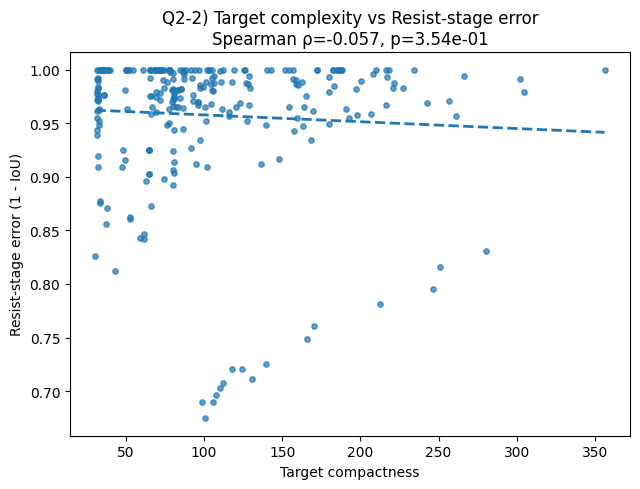

  Spearman rho = -0.057, p = 3.54e-01



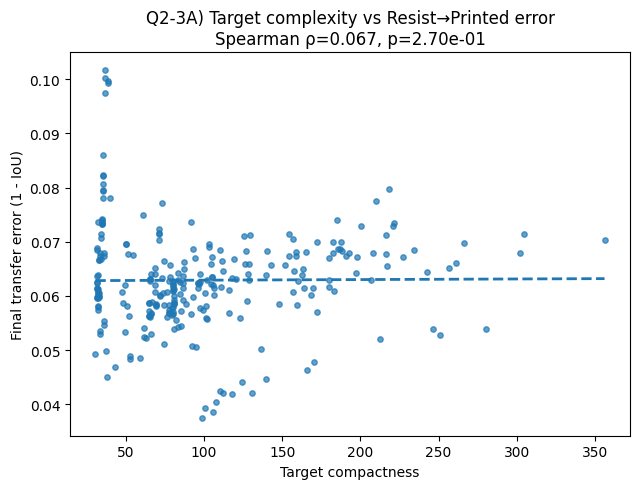

  Spearman rho = 0.067, p = 2.70e-01



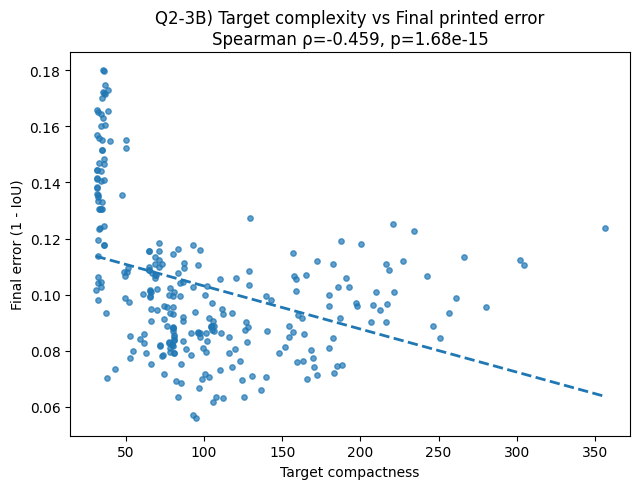

  Spearman rho = -0.459, p = 1.68e-15


[Q2-4] Feature vs Stage error correlation (top rows):
                feature          stage  spearman_rho       p_value
8      target_area_frac    final_error     -0.592930  4.042775e-27
5   target_edge_density    final_error     -0.538869  8.210002e-22
2    target_compactness    final_error     -0.458612  1.683377e-15
9     target_components  optical_error     -0.389006  3.190072e-11
6      target_area_frac  optical_error     -0.376903  1.417270e-10
10    target_components   resist_error     -0.339931  9.356737e-09
7      target_area_frac   resist_error     -0.297475  6.107624e-07
3   target_edge_density  optical_error     -0.287946  1.430026e-06
4   target_edge_density   resist_error     -0.205897  6.485986e-04
0    target_compactness  optical_error     -0.143664  1.796357e-02
Saved: eda_step2_outputs\Q2_4_feature_stage_correlation.csv


In [34]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

CSV_PATH = r'C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\BaekGaeun\eda_6stage_features_errors.csv'
df = pd.read_csv(CSV_PATH)

OUT_DIR = Path("./eda_step2_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Loaded:", CSV_PATH)
print("Shape:", df.shape)

# Helper: scatter + trend
def scatter_with_trend(x, y, xlabel, ylabel, title, out_png):
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    coef = np.polyfit(x, y, 1)
    xx = np.linspace(x.min(), x.max(), 200)
    yy = coef[0] * xx + coef[1]

    rho, p = spearmanr(x, y)

    plt.figure(figsize=(6.5, 5))
    plt.scatter(x, y, s=15, alpha=0.7)
    plt.plot(xx, yy, linestyle="--", linewidth=2)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(
        f"{title}\nSpearman ρ={rho:.3f}, p={p:.2e}"
    )

    plt.tight_layout()
    plt.show()
    print(f"  Spearman rho = {rho:.3f}, p = {p:.2e}\n")



# Q2-1) Target complexity vs Optical error (glp \u2192 litho)

scatter_with_trend(
    x=df["target_compactness"].values,
    y=1.0 - df["iou_pixelILT_litho_t0.40"].values, # Changed from iou_glp_litho_t0.40
    xlabel="Target compactness",
    ylabel="Optical error (1 - IoU)",
    title="Q2-1) Target complexity vs Optical-stage error (pixelILT \u2192 litho)",
    out_png=OUT_DIR / "Q2_1_target_compactness_vs_pixelILT_litho_error.png",
)


# Q2-2) Target complexity vs Resist error (litho \u2192 resist)


scatter_with_trend(
    x=df["target_compactness"].values,
    y=1.0 - df["iou_litho_resist_t0.40"].values,
    xlabel="Target compactness",
    ylabel="Resist-stage error (1 - IoU)",
    title="Q2-2) Target complexity vs Resist-stage error",
    out_png=OUT_DIR / "Q2_2_target_compactness_vs_litho_resist_error.png",
)

# Q2-3) Target complexity vs Final error

# (A) Resist \u2192 Printed
scatter_with_trend(
    x=df["target_compactness"].values,
    y=1.0 - df["iou_resist_printed_t0.40"].values,
    xlabel="Target compactness",
    ylabel="Final transfer error (1 - IoU)",
    title="Q2-3A) Target complexity vs Resist\u2192Printed error",
    out_png=OUT_DIR / "Q2_3A_target_compactness_vs_resist_printed_error.png",
)

# (B) Target \u2192 Printed (누적 결과)
scatter_with_trend(
    x=df["target_compactness"].values,
    y=1.0 - df["iou_target_printed"].values,
    xlabel="Target compactness",
    ylabel="Final error (1 - IoU)",
    title="Q2-3B) Target complexity vs Final printed error",
    out_png=OUT_DIR / "Q2_3B_target_compactness_vs_target_printed_error.png",
)

# Q2-4) Which target feature matters most? (Correlation table)

target_features = [
    "target_compactness",
    "target_edge_density",
    "target_area_frac",
    "target_components",
]

stage_errors = {
    # "optical_error": 1.0 - df["iou_glp_litho_t0.40"], # Removed 'glp' reference
    "optical_error": 1.0 - df["iou_pixelILT_litho_t0.40"], # Using pixelILT as optical stage
    "resist_error": 1.0 - df["iou_litho_resist_t0.40"],
    "final_error": 1.0 - df["iou_target_printed"],
}

rows = []
for feat in target_features:
    for stage, err in stage_errors.items():
        # Ensure there are no NaNs before calculating Spearman correlation
        valid_indices = ~df[feat].isnull() & ~err.isnull()
        if valid_indices.any(): # Only calculate if there's valid data
            rho, p = spearmanr(df[feat][valid_indices], err[valid_indices])
        else:
            rho, p = np.nan, np.nan
        rows.append({
            "feature": feat,
            "stage": stage,
            "spearman_rho": rho,
            "p_value": p,
        })

corr_df = pd.DataFrame(rows)
corr_df = corr_df.sort_values(by="spearman_rho", key=np.abs, ascending=False)

corr_path = OUT_DIR / "Q2_4_feature_stage_correlation.csv"
corr_df.to_csv(corr_path, index=False)

print("\n[Q2-4] Feature vs Stage error correlation (top rows):")
print(corr_df.head(10))
print(f"Saved: {corr_path}")

In [35]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

OUT_DIR = "eda_step3_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

CSV_PATH = r'C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\BaekGaeun\eda_6stage_features_errors.csv'  # 필요시 수정
df = pd.read_csv(CSV_PATH)

print("Loaded:", CSV_PATH)
print("Shape:", df.shape)
print(df.columns.tolist())

Loaded: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\BaekGaeun\eda_6stage_features_errors.csv
Shape: (271, 35)
['mask_name', 'target_area_frac', 'target_perimeter', 'target_components', 'target_compactness', 'target_edge_density', 'shift_target_printed', 'iou_target_pixelILT', 'xor_target_pixelILT', 'iou_target_printed', 'xor_target_printed', 'comp_delta_target_printed', 'iou_pixelILT_litho_t0.30', 'xor_pixelILT_litho_t0.30', 'iou_pixelILT_litho_t0.40', 'xor_pixelILT_litho_t0.40', 'iou_pixelILT_litho_t0.50', 'xor_pixelILT_litho_t0.50', 'iou_litho_resist_t0.30', 'xor_litho_resist_t0.30', 'iou_litho_resist_t0.40', 'xor_litho_resist_t0.40', 'iou_litho_resist_t0.50', 'xor_litho_resist_t0.50', 'iou_resist_printed_t0.30', 'xor_resist_printed_t0.30', 'comp_delta_resist_printed_t0.30', 'iou_resist_printed_t0.40', 'xor_resist_printed_t0.40', 'comp_delta_resist_printed_t0.40', 'iou_resist_printed_t0.50', 'xor_resist_printed_t0.50', 'comp_delta_resist_printe

In [36]:

# Q3-1) Define failure labels

# Define 'final_error' column based on the definition from Step 2
df['final_error'] = 1.0 - df['iou_target_printed']

candidate_final_cols = [c for c in df.columns if "final" in c and "error" in c] + \
                       [c for c in df.columns if ("target" in c and "printed" in c and "error" in c)]

if len(candidate_final_cols) == 0:
    raise ValueError("final error column not found. Columns contain no final_error-like name.")
final_col = candidate_final_cols[0]
print("Using final error column:", final_col)

# 실패 기준: 상위 q (예: 0.90 = 상위10%)
FAIL_Q = 0.90
thr = df[final_col].quantile(FAIL_Q)
df["is_fail"] = (df[final_col] >= thr).astype(int)

print("Fail threshold (quantile):", FAIL_Q, "=>", thr)
print(df["is_fail"].value_counts())

Using final error column: final_error
Fail threshold (quantile): 0.9 => 0.14433284019851422
is_fail
0    243
1     28
Name: count, dtype: int64


Target features: ['target_area_frac', 'target_perimeter', 'target_components', 'target_compactness', 'target_edge_density']
Saved: eda_step3_outputs\Q3_1_fail_vs_normal_feature_effectsize.csv


,feature,mean_fail,mean_norm,cohen_d,median_fail,median_norm
1,target_perimeter,1086.785714,4029.794239,-1.336399,1070.000000,3316.000000
4,target_edge_density,0.000259,0.000961,-1.336399,0.000255,0.000791
0,target_area_frac,0.007900,0.036421,-1.322816,0.007845,0.029280
3,target_compactness,36.000122,107.943392,-1.231520,35.284325,88.724628
2,target_components,2.071429,2.905350,-0.663697,2.000000,2.000000


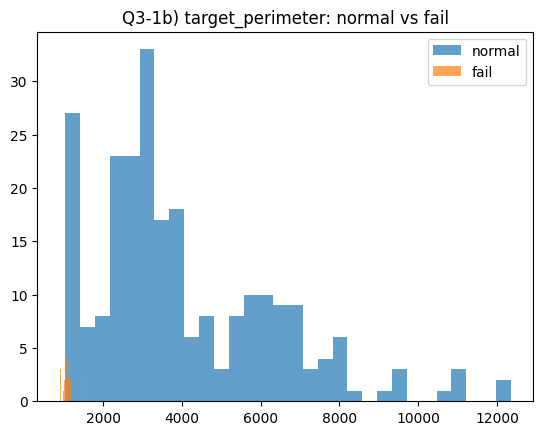

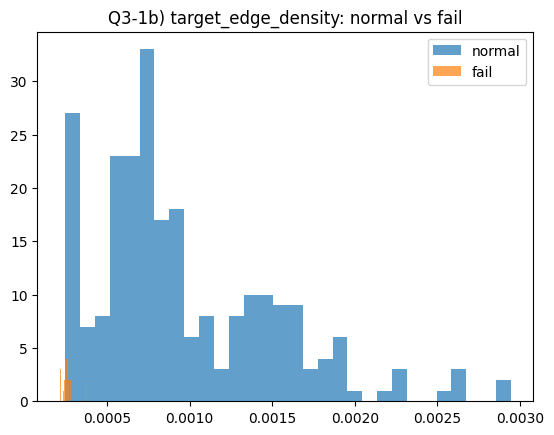

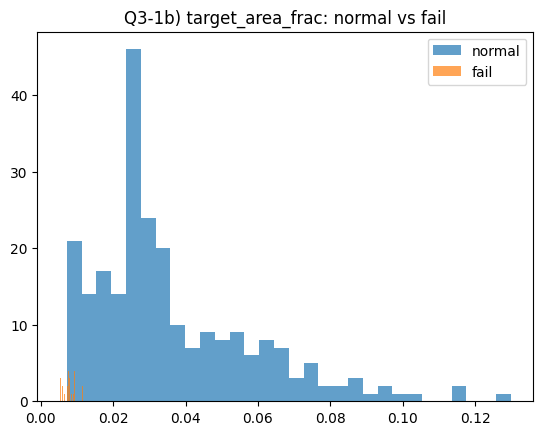

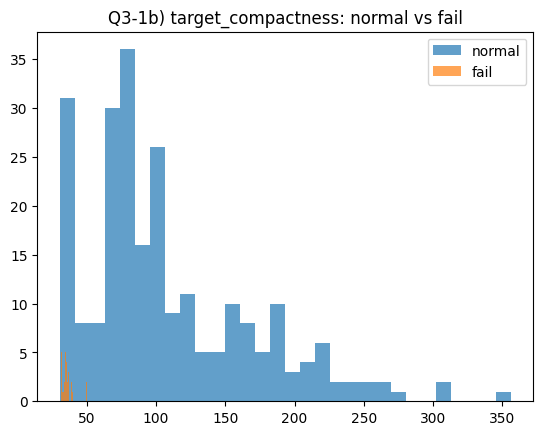

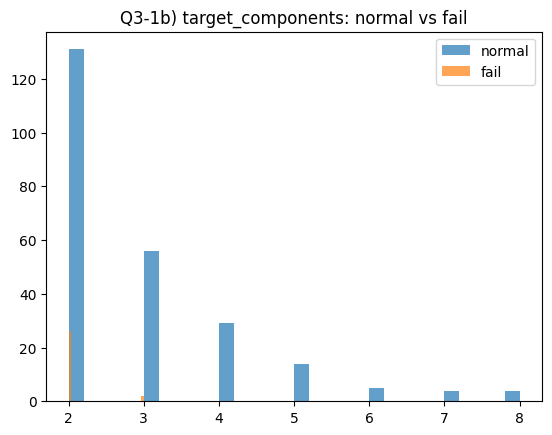

In [37]:
# Q3-1b) Compare distributions: fail vs normal

# target feature만 뽑기 (이름 규칙: target_ 로 시작)
target_feats = [c for c in df.columns if c.startswith("target_")]

# 숫자형만 남기기
target_feats = [c for c in target_feats if pd.api.types.is_numeric_dtype(df[c])]
print("Target features:", target_feats)

fail = df[df["is_fail"] == 1]
norm = df[df["is_fail"] == 0]

rows = []
for f in target_feats:
    a = fail[f].dropna().values
    b = norm[f].dropna().values
    if len(a) < 5 or len(b) < 5:
        continue
    # 효과크기: (평균차 / pooled std) = Cohen's d
    sa, sb = np.std(a, ddof=1), np.std(b, ddof=1)
    pooled = np.sqrt(((len(a)-1)*sa*sa + (len(b)-1)*sb*sb) / (len(a)+len(b)-2))
    d = (np.mean(a) - np.mean(b)) / (pooled + 1e-12)
    rows.append([f, np.mean(a), np.mean(b), d, np.median(a), np.median(b)])

comp = pd.DataFrame(rows, columns=["feature","mean_fail","mean_norm","cohen_d","median_fail","median_norm"])
comp = comp.sort_values("cohen_d", key=lambda s: np.abs(s), ascending=False)

save_path = os.path.join(OUT_DIR, "Q3_1_fail_vs_normal_feature_effectsize.csv")
comp.to_csv(save_path, index=False)
print("Saved:", save_path)
display(comp.head(15))

# 상위 몇 개만 히스토그램 비교 저장
topk = comp.head(6)["feature"].tolist()

for f in topk:
    plt.figure()
    plt.hist(norm[f].dropna(), bins=30, alpha=0.7, label="normal")
    plt.hist(fail[f].dropna(), bins=30, alpha=0.7, label="fail")
    plt.title(f"Q3-1b) {f}: normal vs fail")
    plt.legend()
    plt.show()

PCA explained variance ratio: [0.71811699 0.23970327] sum= 0.9578202649735532


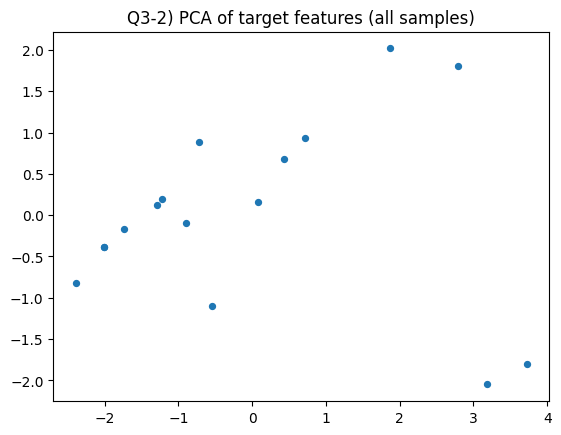

KeyError: 'is_fail'

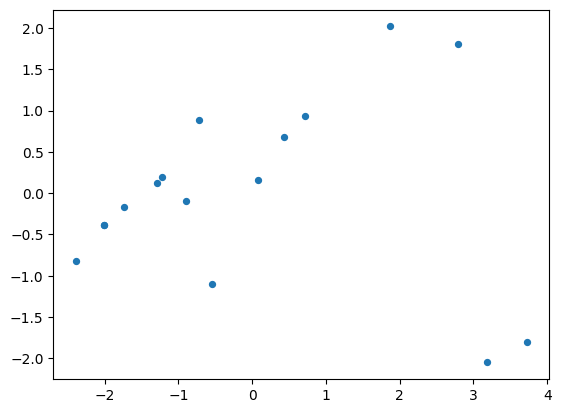

In [58]:
# Q3-2) PCA projection + clustering
X = df[target_feats].fillna(df[target_feats].median())
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(Xz)

print("PCA explained variance ratio:", pca.explained_variance_ratio_, "sum=", pca.explained_variance_ratio_.sum())

plt.figure()
plt.scatter(Z[:,0], Z[:,1], s=18)
plt.title("Q3-2) PCA of target features (all samples)")
plt.show()
# Removed plt.savefig(out, dpi=160, bbox_inches="tight")
# Removed plt.close()
# print("Saved:", out)

# fail만 표시
plt.figure()
plt.scatter(Z[:,0], Z[:,1], s=18)
mask_fail = df["is_fail"].values.astype(bool)
plt.scatter(Z[mask_fail,0], Z[mask_fail,1], s=22)
plt.title("Q3-2) PCA with fail samples highlighted")
plt.show()
# Removed plt.savefig(out, dpi=160, bbox_inches="tight")
# Removed plt.close()
# print("Saved:", out)

# KMeans clustering
K = 4
km = KMeans(n_clusters=K, random_state=0, n_init=10)
df["cluster"] = km.fit_predict(Xz)

# 클러스터별 fail rate / error 요약
summary = df.groupby("cluster").agg(
    n=("cluster","size"),
    fail_rate=("is_fail","mean"),
    final_error_mean=(final_col,"mean"),
    final_error_median=(final_col,"median"),
).reset_index()

out_csv = os.path.join(OUT_DIR, "Q3_2_cluster_summary.csv")
summary.to_csv(out_csv, index=False)
print("Saved:", out_csv)
display(summary)

# PCA에서 클러스터 색칠
plt.figure()
for k in range(K):
    idx = (df["cluster"].values == k)
    plt.scatter(Z[idx,0], Z[idx,1], s=18, label=f"cluster {k}")
plt.legend()
plt.title("Q3-2) PCA colored by KMeans clusters")
plt.show()
# Removed plt.savefig(out, dpi=160, bbox_inches="tight")
# Removed plt.close()
# print("Saved:", out)


Logistic(L1) AUC: 0.9648711943793911
Saved: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\0_Datasets\lithodata\StdMetal\best_patterns_png\Q3_3_logistic_L1_coefficients.csv


target_area_frac      -5.334763
target_perimeter       0.000000
target_components      0.000000
target_compactness     0.000000
target_edge_density    0.000000
dtype: float64

RandomForest AUC: 0.9601873536299765
Saved: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\0_Datasets\lithodata\StdMetal\best_patterns_png\Q3_3_rf_feature_importance.csv


target_area_frac       0.365521
target_perimeter       0.289498
target_edge_density    0.242024
target_compactness     0.101564
target_components      0.001394
dtype: float64

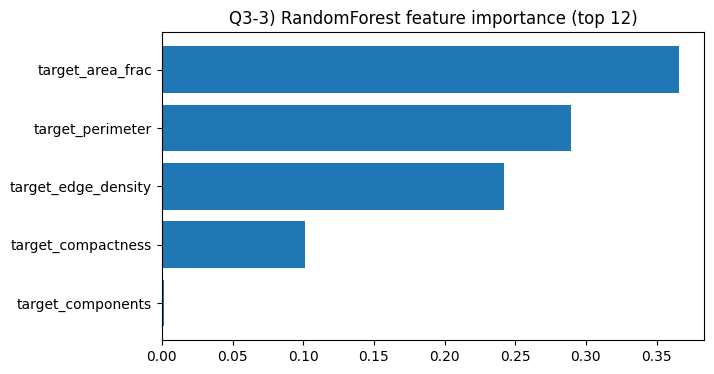

In [50]:
# Q3-3) Multivariate importance (classification: fail vs normal)

# Ensure 'final_error' and 'is_fail' columns are present in df
# This is added for robustness in case previous cells were not run in order
if 'final_error' not in df.columns:
    df['final_error'] = 1.0 - df['iou_target_printed']

if 'is_fail' not in df.columns:
    FAIL_Q = 0.90
    thr = df['final_error'].quantile(FAIL_Q)
    df["is_fail"] = (df['final_error'] >= thr).astype(int)

y = df["is_fail"].values

X_train, X_test, y_train, y_test = train_test_split(
    Xz, y, test_size=0.25, random_state=0, stratify=y
)

# (1) Logistic Regression (L1) => sparse feature selection
logit = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    max_iter=2000,
    random_state=0
)
logit.fit(X_train, y_train)

proba = logit.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, proba)
print("Logistic(L1) AUC:", auc)

coef = pd.Series(logit.coef_[0], index=target_feats)
coef_sorted = coef.reindex(coef.abs().sort_values(ascending=False).index)

out_csv = os.path.join(OUT_DIR, "Q3_3_logistic_L1_coefficients.csv")
coef_sorted.to_csv(out_csv)
print("Saved:", out_csv)
display(coef_sorted.head(12))

# (2) RandomForest importance (nonlinear)
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=0,
    class_weight="balanced",
    max_depth=None,
    min_samples_leaf=2
)
rf.fit(X_train, y_train)
proba_rf = rf.predict_proba(X_test)[:,1]
auc_rf = roc_auc_score(y_test, proba_rf)
print("RandomForest AUC:", auc_rf)

imp = pd.Series(rf.feature_importances_, index=target_feats).sort_values(ascending=False)
out_csv = os.path.join(OUT_DIR, "Q3_3_rf_feature_importance.csv")
imp.to_csv(out_csv)
print("Saved:", out_csv)
display(imp.head(12))

# 중요도 상위 bar plot 저장
top = imp.head(12)[::-1]  # 아래가 큰 값이 되도록 뒤집기
plt.figure(figsize=(7,4))
plt.barh(top.index, top.values)
plt.title("Q3-3) RandomForest feature importance (top 12)")
plt.show()
# out = os.path.join(OUT_DIR, "Q3_3_rf_importance_top12.png")
# plt.savefig(out, dpi=160, bbox_inches="tight")
# plt.close()
# print("Saved:", out)


In [59]:
# Q3-4) Find risky-simple outliers
# Ensure necessary columns and data are prepared for robustness
if 'target_feats' not in globals() or not target_feats:
    target_feats = [c for c in df.columns if c.startswith("target_")]
    target_feats = [c for c in target_feats if pd.api.types.is_numeric_dtype(df[c])]

if 'final_error' not in df.columns:
    df['final_error'] = 1.0 - df['iou_target_printed']

if 'is_fail' not in df.columns:
    FAIL_Q = 0.90
    thr = df['final_error'].quantile(FAIL_Q)
    df["is_fail"] = (df['final_error'] >= thr).astype(int)

if 'cluster' not in df.columns:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans

    X = df[target_feats].fillna(df[target_feats].median())
    scaler = StandardScaler()
    Xz = scaler.fit_transform(X)

    K = 4 # Assuming K=4 from previous clustering step
    km = KMeans(n_clusters=K, random_state=0, n_init=10)
    df["cluster"] = km.fit_predict(Xz)

# 컬럼 후보들 자동 선택
compact_cols = [c for c in df.columns if c == "target_compactness"]
area_cols = [c for c in df.columns if c == "target_area_frac"]

if len(compact_cols)==0 or len(area_cols)==0:
    print("Warning: target_compactness or target_area_frac not found.")
else:
    compact_col = compact_cols[0]
    area_col = area_cols[0]

    # 단순 조건: 하위 30% & 하위 30%
    c_thr = df[compact_col].quantile(0.30)
    a_thr = df[area_col].quantile(0.30)

    simple = df[(df[compact_col] <= c_thr) & (df[area_col] <= a_thr)].copy()

    # 그 중에서 final_error 상위 20개
    worst_simple = simple.sort_values(final_col, ascending=False).head(20)

    out_csv = os.path.join(OUT_DIR, "Q3_4_worst_simple_patterns.csv")
    worst_simple.to_csv(out_csv, index=False)
    print("Saved:", out_csv)
    display(worst_simple[[compact_col, area_col, final_col, "is_fail", "cluster"]].head(20))

Saved: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\0_Datasets\lithodata\StdMetal\best_patterns_png\Q3_4_worst_simple_patterns.csv


,target_compactness,target_area_frac,final_error,is_fail,cluster
9,91.395794,0.033135,0.078648,0,1
7,85.357875,0.032785,0.075481,0,1
4,85.357875,0.032785,0.068467,0,1


Using stage error cols: ['final_error']
Saved: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\0_Datasets\lithodata\StdMetal\best_patterns_png\Q3_5_fail_vs_normal_stage_errors.csv


final_error          
               mean    median
is_fail                      
0          0.071527  0.073616
1          0.081101  0.081101

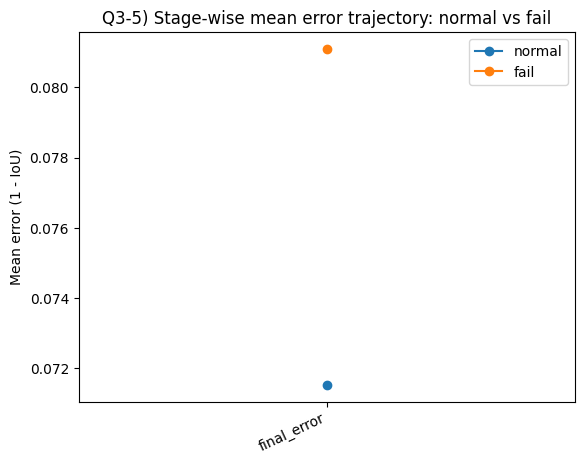

In [60]:
# Q3-5) Compare stage-wise trajectories: fail vs normal
# stage error 컬럼들 자동 탐색: "optical_error", "resist_error", "final_error" 등
stage_error_cols = [c for c in df.columns if c.endswith("_error") and pd.api.types.is_numeric_dtype(df[c])]
prefer = []
for key in ["optical_error", "resist_error", "final_error"]:
    for c in stage_error_cols:
        if c == key:
            prefer.append(c)

if len(prefer) == 0:
    # fallback: 이름에 optical/resist/final 들어간 것 찾기
    prefer = []
    for key in ["optical", "resist", "final"]:
        hits = [c for c in stage_error_cols if key in c]
        if hits:
            prefer.append(hits[0])

print("Using stage error cols:", prefer)

traj = df.groupby("is_fail")[prefer].agg(["mean","median"])
out_csv = os.path.join(OUT_DIR, "Q3_5_fail_vs_normal_stage_errors.csv")
traj.to_csv(out_csv)
print("Saved:", out_csv)
display(traj)

# 시각화 (mean trajectory)
means = df.groupby("is_fail")[prefer].mean()
plt.figure()
x = np.arange(len(prefer))
plt.plot(x, means.loc[0].values, marker="o", label="normal")
plt.plot(x, means.loc[1].values, marker="o", label="fail")
plt.xticks(x, prefer, rotation=25, ha="right")
plt.ylabel("Mean error (1 - IoU)")
plt.title("Q3-5) Stage-wise mean error trajectory: normal vs fail")
plt.legend()
plt.show()

In [61]:
import numpy as np
import pandas as pd
from pathlib import Path

CSV_PATH = r'C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\BaekGaeun\eda_6stage_features_errors.csv' # 필요시 수정
df = pd.read_csv(CSV_PATH)

# Ensure OUT_DIR is set for saving (consistent with Step 3 outputs)
OUT_DIR = Path("./eda_step3_outputs")
OUT_DIR.mkdir(exist_ok=True)

# 1) Columns (robust)
# final similarity: target vs printed
if "iou_target_printed" not in df.columns:
    raise ValueError("Missing column: iou_target_printed")

# required features
required = ["mask_name", "target_area_frac", "target_edge_density", "target_compactness", "target_components"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df = df.copy()
df["final_error"] = 1.0 - df["iou_target_printed"]  # 낮을수록 좋음


# 2) Define “circuit efficiency” proxy
# 여기선 회로 효율을 "집적/활성 면적"의 proxy로 target_area_frac(높을수록) 사용.
# (진짜 회로 RC/Power 등은 데이터에 없어서 proxy로 해석해야 함)

# 3) Sweet-spot filtering (너무 극단 제외)
# - error는 하위 20% (좋은 것)
# - area_frac는 상위 40% (너무 희박한 패턴 제외)
# - edge_density/compactness는 중간대 선호 (너무 단순/너무 복잡 배제)
# - components는 너무 큰 것 제외 (고립 섬 많으면 공정 취약 가능)

q_err = df["final_error"].quantile(0.20)       # 낮을수록 좋음
q_area = df["target_area_frac"].quantile(0.60) # 높을수록 좋음

# 중간대 범위(20~80 분위)
ed_lo, ed_hi = df["target_edge_density"].quantile(0.20), df["target_edge_density"].quantile(0.80)
cp_lo, cp_hi = df["target_compactness"].quantile(0.20), df["target_compactness"].quantile(0.80)

# components 상한(90 분위)
comp_hi = df["target_components"].quantile(0.90)

candidates = df[
    (df["final_error"] <= q_err) &
    (df["target_area_frac"] >= q_area) &
    (df["target_edge_density"].between(ed_lo, ed_hi)) &
    (df["target_compactness"].between(cp_lo, cp_hi)) &
    (df["target_components"] <= comp_hi)
].copy()

print("Candidates (sweet-spot) =", len(candidates), "/", len(df))

# 4) Score ranking (single score)
# 점수 설계:((가중치!!))
# - final_error: 작을수록 좋음 (가장 중요)
# - area_frac: 클수록 좋음
# - edge/compactness: 중간대일수록 좋음 (중간에서 멀어질수록 감점)
# - components: 작을수록 좋음 (약하게)

def z(x):
    x = x.astype(float)
    return (x - x.mean()) / (x.std() + 1e-12)

# 중간대 선호: "중앙값에서의 거리"를 감점으로 사용
ed_center = df["target_edge_density"].median()
cp_center = df["target_compactness"].median()

candidates["ed_penalty"] = np.abs(candidates["target_edge_density"] - ed_center)
candidates["cp_penalty"] = np.abs(candidates["target_compactness"] - cp_center)

# 스코어(가중치 조절 가능)
# - error가 가장 중요: -2.0
# - area는 +1.2
# - edge/compactness penalty는 -0.6, -0.4
# - components는 -0.2 (약하게)
candidates["score"] = (
    -2.0 * z(candidates["final_error"]) +
    +1.2 * z(candidates["target_area_frac"]) +
    -0.6 * z(candidates["ed_penalty"]) +
    -0.4 * z(candidates["cp_penalty"]) +
    -0.2 * z(candidates["target_components"])
)

topN = 20
best = candidates.sort_values("score", ascending=False).head(topN)

print("\n=== Top patterns (sweet-spot ranking) ===")
print(best[["mask_name", "final_error", "target_area_frac", "target_edge_density", "target_compactness", "target_components", "score"]])

best.to_csv(OUT_DIR / "best_sweet_spot_patterns.csv", index=False, encoding="utf-8-sig")
print("\nSaved:", OUT_DIR / "best_sweet_spot_patterns.csv")

# 5) (Optional) Pareto front: minimize error, maximize area

def pareto_front_min_error_max_area(df_in, err_col="final_error", area_col="target_area_frac"):
    data = df_in[[err_col, area_col]].to_numpy()
    is_pareto = np.ones(len(df_in), dtype=bool)
    for i, (e, a) in enumerate(data):
        if not is_pareto[i]:
            continue
        # (error <= e and area >= a) 이면서 둘 중 하나 strict이면 i는 지배됨
        dominates = (data[:,0] <= e) & (data[:,1] >= a) & ((data[:,0] < e) | (data[:,1] > a))
        if dominates.any():
            is_pareto[i] = False
    return df_in[is_pareto].copy()

pf = pareto_front_min_error_max_area(df, "final_error", "target_area_frac")
pf = pf.sort_values(["final_error", "target_area_frac"], ascending=[True, False])

print("\nPareto front size =", len(pf))
pf.head(30).to_csv(OUT_DIR / "pareto_front_error_vs_area.csv", index=False, encoding="utf-8-sig")
print("Saved:", OUT_DIR / "pareto_front_error_vs_area.csv")

Candidates (sweet-spot) = 16 / 271

=== Top patterns (sweet-spot ranking) ===
                  mask_name  final_error  target_area_frac  \
265        TLAT_X1__2_0.png     0.055977          0.040196   
219      SDFFRS_X2__0_0.png     0.057237          0.039758   
201         OR3_X2__0_1.png     0.063593          0.074096   
1          AND3_X2__0_0.png     0.071705          0.071727   
141       NAND4_X2__0_0.png     0.068467          0.032785   
227       SDFFR_X1__0_0.png     0.063562          0.033531   
123         DLL_X1__0_0.png     0.071750          0.033585   
142       NAND4_X2__1_0.png     0.075481          0.032785   
120         DLH_X1__1_0.png     0.076363          0.044679   
136        MUX2_X2__1_1.png     0.078648          0.033135   
52   CLKGATETST_X2__2_0.png     0.079249          0.044627   
150        NOR3_X2__0_1.png     0.079603          0.034292   
53   CLKGATETST_X2__3_0.png     0.080845          0.034342   
101        DFFS_X2__1_0.png     0.079164          0.05

In [62]:
DATA_ROOT = Path(r"C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\0_Datasets\lithodata\StdMetal")

# Define the output directory for Step 3 outputs, assuming it's consistent
OUT_DIR_STEP3 = Path("./eda_step3_outputs")
CSV_PATH = OUT_DIR_STEP3 / "best_sweet_spot_patterns.csv"

STAGES = {
    "target": DATA_ROOT / "target",
    # "glp": DATA_ROOT / "glp",
    "litho": DATA_ROOT / "litho",
    "resist": DATA_ROOT / "resist",
    "printed": DATA_ROOT / "printed",
    "pixelILT": DATA_ROOT / "pixelILT",
}

OUT_DIR = DATA_ROOT / "best_patterns_png"
OUT_DIR.mkdir(exist_ok=True)

df = pd.read_csv(CSV_PATH)
print("Loaded patterns:", len(df))

Loaded patterns: 16


In [ ]:
def load_gray(path: Path):
    if not path.exists():
        print(f"[WARN] Missing file: {path}")
        return None
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    return img

In [64]:
def plot_pattern_row(mask_name, save_path):
    fig, axes = plt.subplots(1, len(STAGES), figsize=(3.5 * len(STAGES), 3))
    fig.suptitle(mask_name, fontsize=12)

    for ax, (stage, folder) in zip(axes, STAGES.items()):
        # 확장자 처리
        fname = mask_name
        if not fname.lower().endswith(".png"):
            fname += ".png"

        img = load_gray(folder / fname)

        if img is None:
            ax.set_title(stage)
            ax.axis("off")
            continue

        ax.imshow(img, cmap="gray")
        ax.set_title(stage)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

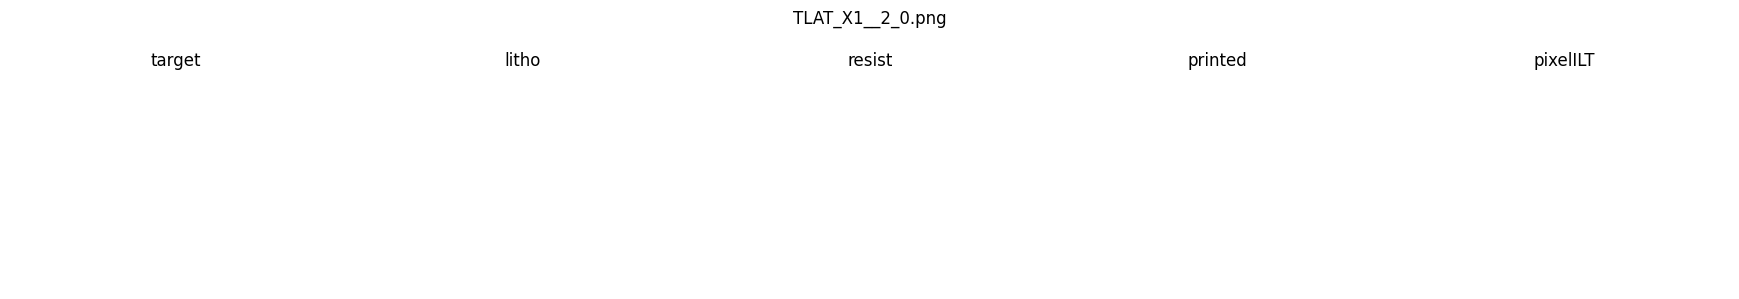

Saved: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\0_Datasets\lithodata\StdMetal\best_patterns_png\00_TLAT_X1__2_0.png_row.png


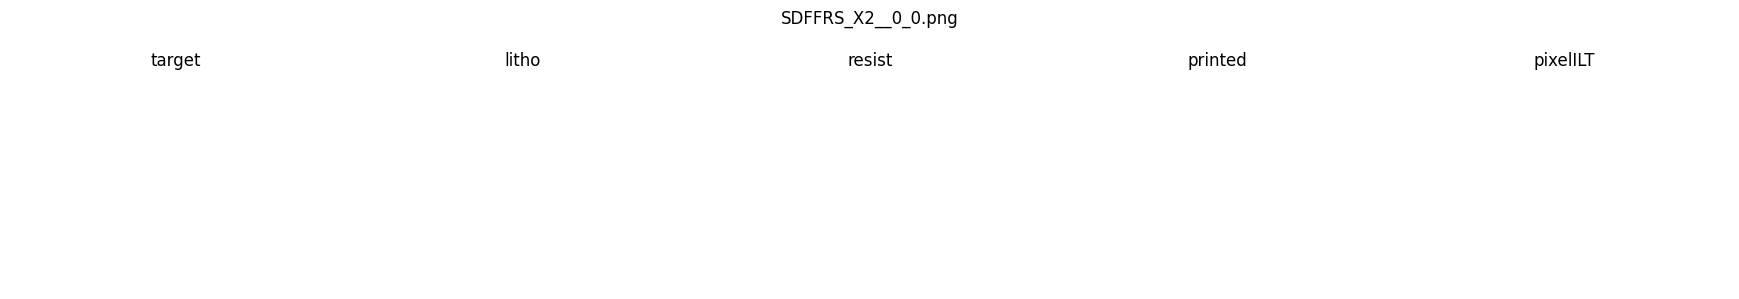

Saved: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\0_Datasets\lithodata\StdMetal\best_patterns_png\01_SDFFRS_X2__0_0.png_row.png


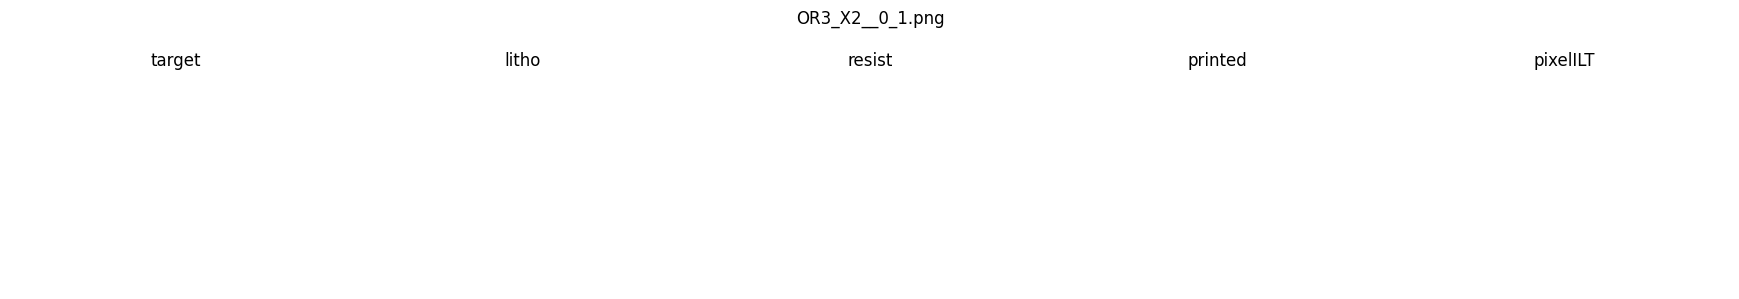

Saved: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\0_Datasets\lithodata\StdMetal\best_patterns_png\02_OR3_X2__0_1.png_row.png


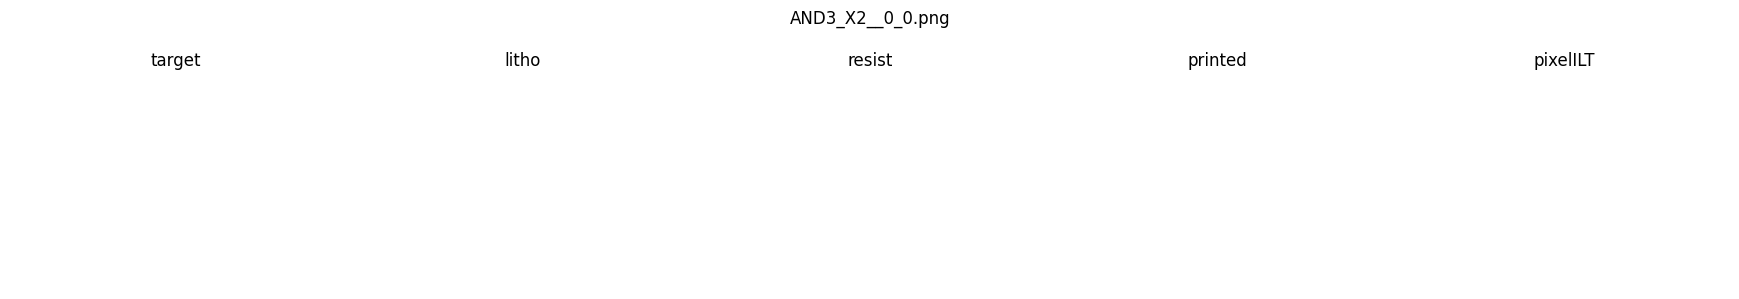

Saved: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\0_Datasets\lithodata\StdMetal\best_patterns_png\03_AND3_X2__0_0.png_row.png


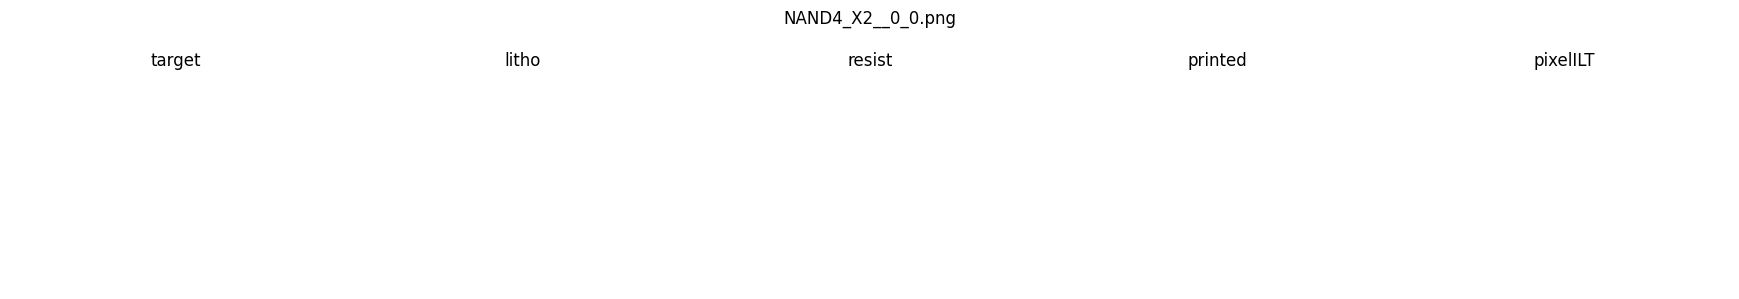

Saved: C:\Users\asap0\OneDrive\바탕 화면\yonsei\26-1 DSL\eda\SemiConductor_EDA_2602\LithoBench\0_Datasets\lithodata\StdMetal\best_patterns_png\04_NAND4_X2__0_0.png_row.png


In [65]:
TOP_N = 5

for i, row in df.head(TOP_N).iterrows():
    mask = row["mask_name"]
    out_path = OUT_DIR / f"{i:02d}_{mask}_row.png"

    plot_pattern_row(mask, out_path)
    print("Saved:", out_path)